# Applying Different Kernels to Images through Fourier Transforms

Author: Pramith Devulapalli

An alternative way to convolve kernels with an image is through Fourier Transforms. The convolution theorems states that the Fourier Transform of the image and kernel, point-wise multiplication of those transforms, and the inverse Fourier Transform of the product is equivalent to applying convolving a kernel with an image.

Convolution Theorem:
$$f*g= \mathcal{F}^{-1}\big\{\mathcal{F}\{f\}\cdot\mathcal{F}\{g\}\big\}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import scipy.fftpack
import scipy.misc as misc
import cv2
import math
import os

In [3]:
img = cv2.imread('MJ_Bulls.jpg', 0)  # Greyscale image

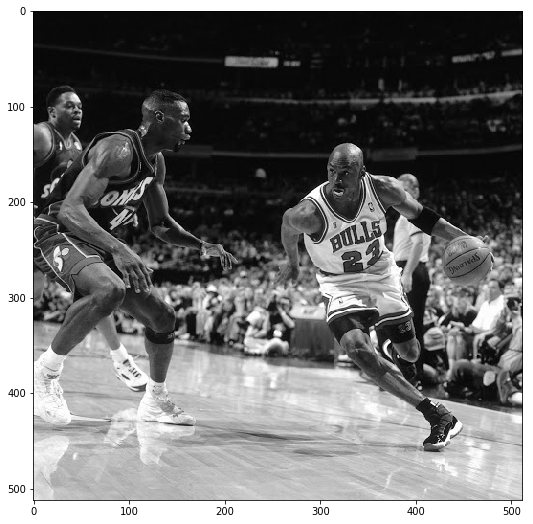

In [4]:
plt.figure(figsize=(9,9))
plt.imshow(img, cmap ='gray')

In [5]:
def bit_reversal(a):
    array = np.zeros(a.shape)
    array = array.astype('complex')
    log = int(math.log(array.size, 2))
    for n in range(a.size):
        b = '{:0{width}b}'.format(n, width=log)
        array[n] = a[int(b[::-1], 2)]
    return array

def ButterflyComputationFFT_Exp(input_array):
    N = input_array.size
    twiddle = complex(np.cos(2.0*np.pi/N), -1.0*np.sin(2.0*np.pi/N))
    for i in range(int(N/2)):
        factor = twiddle**i
        a = input_array[int(i)]
        input_array[int(i)] = a + factor*input_array[int(i+N/2)]
        input_array[int(i+N/2)] = a + -1.0*factor*input_array[int(i+N/2)]
    return input_array

def ButterflyComputationIFT(input_array):
    output = np.zeros(input_array.shape)
    output = output.astype('complex')
    if input_array.size == 1:
        return input_array[0]
    else:
        N = input_array.size
        half = N/2
        fl = N
        twiddle = complex(np.cos(2.0*np.pi/fl), np.sin(2.0*np.pi/fl))
        for i in range(int(half)):
            factor = twiddle**(i)
            output[int(i)] = input_array[int(i)] + factor*input_array[int(i+half)]
            output[int(i+half)] = input_array[int(i)] + -1.0*factor*input_array[int(i+half)]
    return output

def FFT_Exp(ar):
    complex_array = np.zeros(ar.shape)
    complex_array = complex_array.astype('complex')
    complex_array = bit_reversal(ar)
    iterations = math.log(ar.size, 2)-1
    while (iterations > -1):
        step = complex_array.size/(2**iterations)
        j = 0
        while (j < complex_array.size):
            complex_array[int(j):int(j+step)] = ButterflyComputationFFT_Exp(complex_array[int(j):int(j+step)])
            j = j + step
        iterations = iterations - 1
        #print(complex_array)
    return complex_array

# Input array must be a power of 2
def IFFT(ar):
    complex_array = np.zeros(ar.shape)
    complex_array = complex_array.astype('complex')
    complex2_array = bit_reversal(ar)
    iterations = math.log(ar.size, 2)-1
    while (iterations > -1):
        arrayList = np.split(complex2_array, 2**(iterations))
        length = complex2_array.size/len(arrayList)
        for j in range(int(len(arrayList))):
            complex_array[int(j*length):int((j+1)*length)] = ButterflyComputationIFT(arrayList[int(j)])
        iterations = iterations - 1
        complex2_array = complex_array
    return complex_array/complex_array.size

def ConvertToDCT_Exp(fft_input):
    fft = np.zeros((2*fft_input.size))
    fft[:fft_input.size] = fft_input
    fft[fft_input.size:] = 0
    dct = np.zeros(fft.shape)
    dct = dct.astype('complex')
    dct = FFT_Exp(fft)
    for i in range(len(dct)):
        dct[i] = 2*dct[i]*np.exp(-1j*np.pi*i/(2*fft_input.size))
    return dct.real[0:fft_input.size]

def DCT_Normalized(dct):
    for i in range(len(dct)):
        if i == 0:
            dct[i] = dct[i]*np.sqrt(1/(4*dct.size))
        else:
            dct[i] = dct[i]*np.sqrt(1/(2*dct.size))
    return dct

def DCT2(arr, N):
    output = np.zeros((N, N))
    for i in range(N):
        output[i,:] = DCT_Normalized(ConvertToDCT_Exp(arr[i,:]))
    
    for j in range(N):
        output[:,j] = DCT_Normalized(ConvertToDCT_Exp(output[:,j]))
    return output

def IDCT_2d(dct):
    return scipy.fftpack.idct(scipy.fftpack.idct(dct.T, norm='ortho').T, norm='ortho')

In [7]:
# The box kernel sets the size of the specificed kernel for the box filter
def box_kernel(n):
    return np.ones((n,n), np.float64)/(n*n)

# The zero padding function pads 0s around the original image so that the box filter can operate the kernel on edge pixels 
def zero_padding(image, kernel):
    array = np.zeros((image.shape[0]+kernel.shape[0]-1, image.shape[1]+kernel.shape[1]-1), np.float64)
    row1 = int((kernel.shape[0]-1)/2)
    row2 = int(row1 + image.shape[0]) 
    col1 = int((kernel.shape[1]-1)/2)
    col2 = int(col1 + image.shape[1])
    array[row1:row2,col1:col2] = image
    return array

# Greyscale blur filter that takes in a kernel and applies it to the image
def greyscale_blur_filter(image, kernel):
    x1 = int((kernel.shape[0] - 1)/2)
    x2 = int(x1 + image.shape[0])
    y1 = int((kernel.shape[1] - 1)/2)
    y2 = int(y1 + image.shape[1])
    array = zero_padding(image, kernel)
    arrayOut = np.zeros(image.shape, dtype=np.uint8)
    for x in range(x1, x2):
        for y in range(y1, y2):
            xOrig = x-(kernel.shape[0]-1)/2
            yOrig = y-(kernel.shape[1]-1)/2
            multiply = array[int(xOrig):int(xOrig+kernel.shape[0]),int(yOrig):int(yOrig+kernel.shape[1])]
            replace = np.multiply(multiply, kernel)
            arrayOut[x-x1,y-y1] = int(np.sum(replace))
        
    return arrayOut

# Bilinear kernel
def bilinear_kernel(n):
    raw = np.ones((n,n),np.float64)/(n*n)
    half = math.ceil(n/2)
    decrement = math.floor(n/2)-1
    for i in range(0,raw.shape[0]):
        if i > half-1:
            raw[i,0:raw.shape[1]] = raw[decrement,0:raw.shape[1]]
            decrement = decrement - 1
        else:
            for j in range(0, half):
                raw[i,j] = (i+1)*(j+1)
            raw[i,(j+1):raw.shape[1]] = raw[i,j-1::-1]
    return raw/np.sum(raw)

# Two Dimensional Gaussian function
def TwoD_gaussian_function(x,y,sigma,mean):
    return (1./(2.*np.pi*sigma**2))*np.exp(-1*(((x-mean)**2 + (y-mean)**2)/(2.*sigma**2)))

# Gaussian kernel 
def gaussian_kernel(n):
    sigma = math.ceil(n/2)/3
    mean = math.floor(n/2)
    gauss = np.ones((n,n),np.float64)
    for i in range(0, n):
        for j in range(0, n):
            gauss[i,j] = TwoD_gaussian_function(j,i,sigma,mean)
    return gauss

General Procedure to Perform FFT Convolution:
1. Zero-pad the kernel so it has the same dimensions as the image
2. Take the FFT of the image.
3. Take the FFT of the kernel.
4. Perform point-wise multiplications of both the transforms.
5. Take the inverse FFT of the product.
6. Extract only the real part of the IFFT
7. Rotate different quadrants of the image into the right place.
8. Display the FFT Convolution on the image.


To prove that the convolution theorem is true, I built a simple box kernel that when convolved on an image, it takes the average of the surrounding pixel values. Below, I display an image with a 5x5 box kernel applied on the image.  

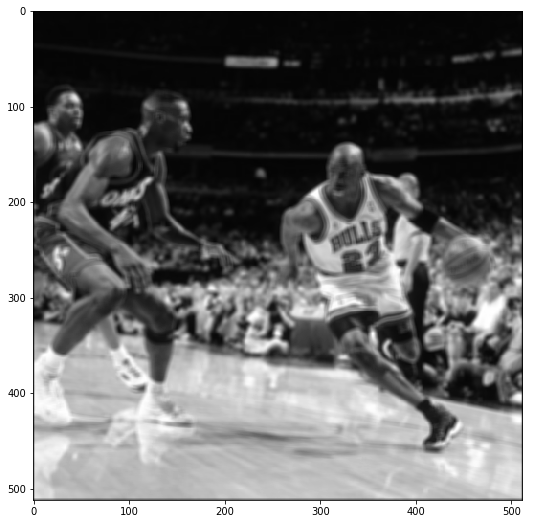

In [8]:
image = greyscale_blur_filter(img, box_kernel(5))
plt.figure(figsize=(9,9))
plt.imshow(image, cmap='gray')

In [9]:
def FFT_2d(im):
    return scipy.fftpack.fft(scipy.fftpack.fft(im.T).T)

def IFFT_2d(im):
    return scipy.fftpack.ifft(scipy.fftpack.ifft(im.T).T)
b = box_kernel(3)
zero_padding(b, box_kernel(6))

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.11111111,  0.11111111,  0.11111111,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.11111111,  0.11111111,  0.11111111,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.11111111,  0.11111111,  0.11111111,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

Below is the resulting raw image from applying the convolution theorem. 

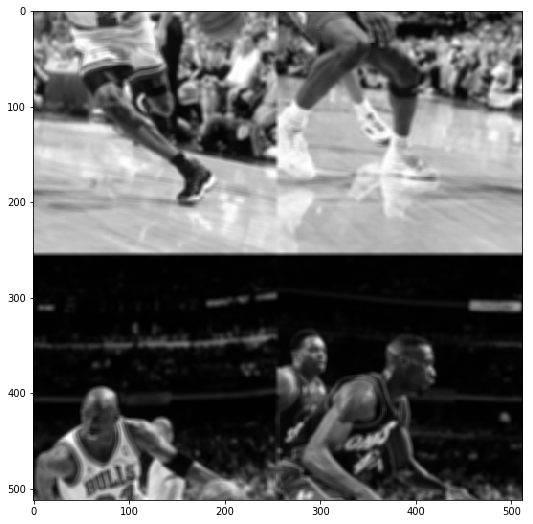

In [10]:
a = box_kernel(5)
k = zero_padding(a, box_kernel(508))
K = FFT_2d(k)
I = FFT_2d(img)
M = np.multiply(K,I)
R = IFFT_2d(M)
plt.figure(figsize=(9,9))
plt.imshow(abs(R.real.astype('int')), cmap='gray')

The following section shows the application of my FFT convolution function for the box kernel, bilinear kernel, and gaussian kernel. 

Zero padding
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
FFT-2D zero padding
[[ 1.00000000 +0.00000000e+00j -0.99977412 -1.22696903e-02j
   0.99909671 +2.45264476e-02j ..., -0.99796844 +3.67573542e-02j
   0.99909671 -2.45264476e-02j -0.99977412 +1.22696903e-02j]
 [-0.99977412 -1.22696903e-02j  0.99939775 +2.45338377e-02j
  -0.99857010 -3.67795148e-02j ...,  0.99819402 -2.45042878e-02j
  -0.99917197 +1.22623004e-02j  0.99969884 +3.80338122e-16j]
 [ 0.99909671 +2.45264476e-02j -0.99857010 -3.67795148e-02j
   0.99759269 +4.90085862e-02j ..., -0.99796851 +1.22475310e-02j
   0.99879578 +2.86229374e-16j -0.99917197 -1.22623004e-02j]
 ..., 
 [-0.99796844 +3.67573542e-02j  0.99819402 -2.45042878e-02j
  -0.99796851 +1.22475310e-02j ...,  0.99458990 -7.33653588e-02j
  -0.99616546 +6.12007722e-02j  0.99729202 -4.89938151e-02j]
 [ 0.99909671 -2

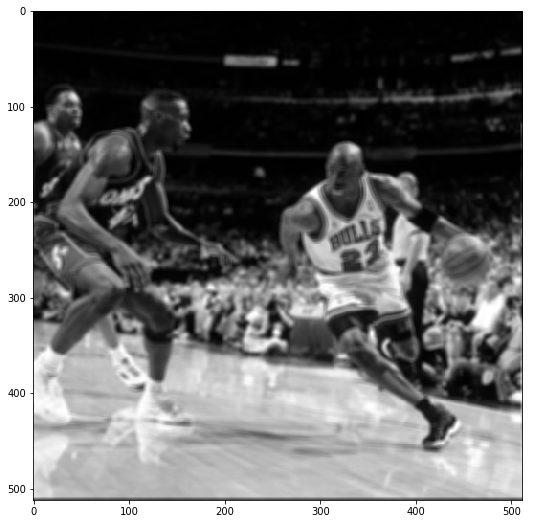

In [11]:
def FFT_Convolution(image, kernel):
    num = np.sqrt(image.size) - np.sqrt(kernel.size) + 1
    k = zero_padding(kernel, box_kernel(int(num)))
    print('Zero padding')
    print(k)
    K = FFT_2d(k)
    print('FFT-2D zero padding')
    print(K)
    I = FFT_2d(image)
    print('FFT-2D of image')
    print(I)
    M = np.multiply(K,I)
    print('Dot Product')
    print(M)
    R = IFFT_2d(M)
    print('IFFT-2D')
    print(R)
    return R

    
def image_rotations(image, N):
    final_image = np.zeros(image.shape)
    N = int(N/2)
    #4th quadrant to 2nd quadrant
    final_image[:N, :N] = image[N:, N:].real
    #1st quadrant to 3rd quadrant
    final_image[N:, :N] = image[0:N, N:].real
    #3rd quadrant to 1st quadrant
    final_image[:N, N:] = image[N:, 0:N].real
    #2nd quadrant to 4th quadrant
    final_image[N:, N:] = image[0:N, 0:N].real
    return final_image

plt.figure(figsize=(9,9))
plt.imshow(image_rotations(FFT_Convolution(img, box_kernel(5)), 512), cmap='gray')

Using the self-built FFT algorithms from exercise 1, I have constructed the two dimensional FFT and IFFT. In this section, I will perform the 5x5 box kernel (as I did above using scipy's fft module) and use my 2-d FFT and 2-D IFFT to perform an FFT convolution on the image. As a proof of correctness, I performed tests (similar to the dct) to make sure that my 2-D FFT and IFFT match up to those of scipy.fftpack. Additionally, you can compare the convolved images using scipy and my personal FFT functions and they are exactly the same. 

In [12]:
def FFT2(arr, N):
    output = np.zeros((N,N))
    output = output.astype('complex')
    for i in range(N):
        output[i, :] = FFT_Exp(arr[i,:])
    for j in range(N):
        output[:, j] = FFT_Exp(output[:, j])
    return output

def IFFT2(arr, N):
    output = np.zeros((N,N))
    output = output.astype('complex')
    for i in range(N):
        output[i, :] = IFFT(arr[i,:])
    for j in range(N):
        output[:, j] = IFFT(output[:, j])
    return output

def FFT_Convolution_Custom(image, kernel):
    N = np.sqrt(image.size)
    num = np.sqrt(image.size) - np.sqrt(kernel.size) + 1
    k = zero_padding(kernel, box_kernel(int(num)))
    K = FFT2(k, int(N))
    I = FFT2(image, int(N))
    M = np.multiply(K,I)
    R = IFFT2(M, int(N))
    return R

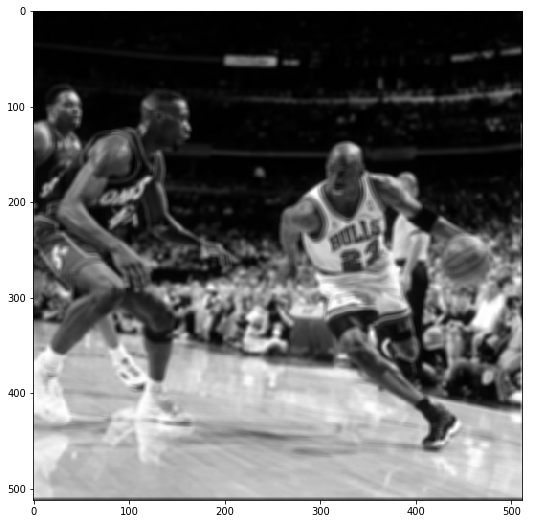

In [13]:
# Box kernel
plt.figure(figsize=(9,9))
plt.imshow(image_rotations(FFT_Convolution_Custom(img, box_kernel(5)), 512), cmap='gray')

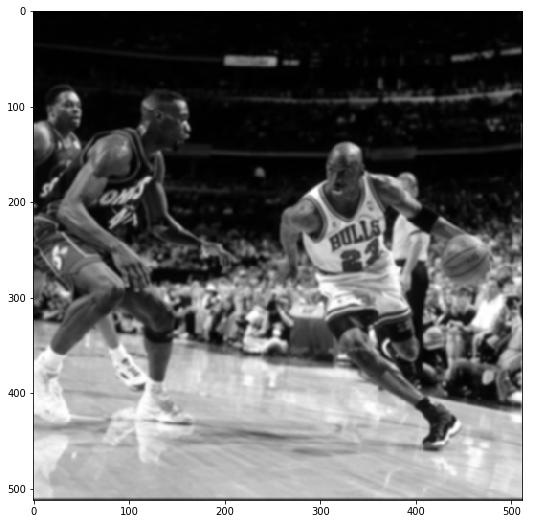

In [94]:
# Bilinear kernel
plt.figure(figsize=(9,9))
plt.imshow(image_rotations(FFT_Convolution(img, bilinear_kernel(5)), 512), cmap='gray')

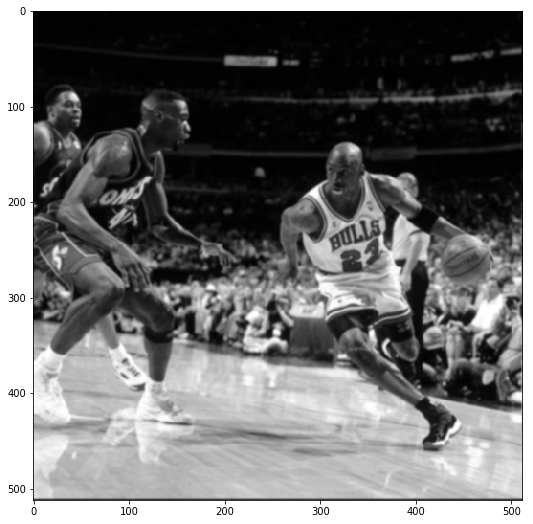

In [95]:
# Gaussian kernel
plt.figure(figsize=(9,9))
plt.imshow(image_rotations(FFT_Convolution(img, gaussian_kernel(5)), 512), cmap='gray')